<a href="https://colab.research.google.com/github/tensorflow-project/FineTuning/blob/main/four_emotions/training_four_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow-project/FineTuning

Cloning into 'FineTuning'...
remote: Enumerating objects: 933, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 933 (delta 162), reused 39 (delta 39), pack-reused 732
Receiving objects: 100% (933/933), 136.97 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (671/671), done.


In [2]:
import sys
import os
from google.colab import drive
import numpy as np

py_file_location = "/content/FineTuning/four_emotions"
sys.path.append(os.path.abspath(py_file_location))
py_file_location = "/content/FineTuning/models"
sys.path.append(os.path.abspath(py_file_location))

import textual_inversion_four_emotions as txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
202761/202761 [==============================] - 0s 2us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


136824240/136824240 [==============================] - 2s 0us/step


In [3]:
### embeddings for cosine similarity
sticker_embedding = []
cosine_similarity = []
cosine_similarity.append(txt.cosine_sim(txt.get_embedding("broccoli"), txt.get_embedding(txt.placeholder_token)))

In [ ]:
### how long to train for
epochs = 10
epoch_num = list(range(epochs+1))
txt.training(epoch=epochs, model=txt.stable_diffusion, data=txt.train_ds, sticker_embedding=sticker_embedding, cosine_similarity=cosine_similarity)

Epoch 5/10:  15%|█▌        | 77/500 [02:06<11:18,  1.60s/it]

In [7]:
### where to store your newly generated weights
drive.mount("/content/drive")
path = '/content/drive/MyDrive/10weights_with_function.npy'

Mounted at /content/drive


In [8]:
###get the weights of the text encoder and save the to Google Drive
text_encoder_weights = np.array(txt.stable_diffusion.text_encoder.get_weights())

### Save the weights array to a file on your Google Drive
np.save(path, text_encoder_weights)

<ipython-input-8-0443ae8bd6c9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_encoder_weights = np.array(txt.stable_diffusion.text_encoder.get_weights())


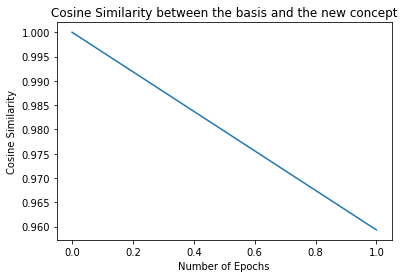

In [9]:
### klappt noch nicht
txt.cosine_plot(epoch_num, cosine_similarity)